In [1]:
import os
import pandas as pd
from openpyxl.styles.builtins import output
from sipbuild.generator.outputs import output_api
from sqlalchemy import create_engine
from sympy.physics.units import katal

import openmimic as om

# db configuration
username = 'root'
password = os.getenv('AIMED_PW')
host = '172.28.8.103'
port = '3306'
database = "MIMIC_III"
db_engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

# om configuration
om.Config.mimic_path = "../mimic3_csv/"
processed_data_path = "./processed_data/"

In [2]:
import importlib

def reload_all():
    importlib.reload(om)
    importlib.reload(om.chartevents)
    importlib.reload(om.chartevents_engineering)
    # importlib.reload(om.cohort)
    importlib.reload(om.config)
    importlib.reload(om.utils)
    importlib.reload(om.inputevents_mv)
    importlib.reload(om.inputevents_mv_engineering)
    importlib.reload(om.mimic_preprocessor)
    importlib.reload(om.patient_static)
    importlib.reload(om.patient_static_engineering)
    importlib.reload(om.outputevents)
    importlib.reload(om.outputevents_engineering)

reload_all()

# Patient_static

In [2]:
# query = "SELECT * FROM patient_static"
# patients_all = pd.read_sql(query, db_engine)
patients_static_csv = pd.read_csv(processed_data_path+"patients_static.csv")
patients_static_T_info_csv = pd.read_csv(processed_data_path+"patients_static_T_info.csv")

patients_static = om.PatientStatic()
patients_static.load_processed(patients_static_csv, patients_static_T_info_csv)
# patients_static.load(patients_all)
# patients_static.patients_T_info

# Chartevents

In [12]:
chartevents_items = (769, 220644, 772, 1521, 227456, 773, 225612, 227073, 770, 220587, 227443, 848, 225690, 1538, 225651, 803, 781, 1162, 225624, 225625, 786, 1522, 816, 225667, 116, 89, 90, 220074, 113, 220602, 226536, 1523, 788, 789, 1524, 220603, 787, 857, 225698, 777, 223679, 791, 1525, 220615, 224643, 225310, 220180, 8555, 220051, 8368, 8441, 8440, 227468, 1528, 806, 189, 727, 223835, 190, 198, 220621, 225664, 811, 807, 226537, 1529, 211, 220045, 226707, 226730, 1394, 813, 220545, 220228, 814, 818, 225668, 1531, 220635, 1532, 821, 456, 220181, 224, 225312, 220052, 52, 6702, 224322, 646, 834, 220277, 220227, 226062, 778, 220235, 779, 227466, 825, 1533, 535, 224695, 860, 223830, 1126, 780, 220274, 1534, 225677, 827, 224696, 543, 828, 227457, 224700, 506, 220339, 512, 829, 1535, 227464, 227442, 227467, 1530, 815, 1286, 824, 227465, 491, 492, 220059, 504, 833, 224422, 618, 220210, 224689, 614, 651, 224690, 615, 224688, 619, 837, 1536, 220645, 226534, 626, 442, 227243, 224167, 220179, 225309, 6701, 220050, 51, 455, 223761, 677, 676, 679, 678, 223762, 224685, 682, 224684, 683, 684, 224686, 1539, 849, 851, 227429, 859, 226531, 763, 224639, 226512, 861, 1542, 220546, 1127 )
query = f"SELECT * FROM CHARTEVENTS WHERE ITEMID IN {chartevents_items} ORDER BY CHARTTIME;"
chartevents_raw = pd.read_sql(query, db_engine)

In [3]:
chartevents_raw = pd.read_csv(processed_data_path+"raw_chartevents.csv")
chartevents_raw["CHARTTIME"] = pd.to_datetime(chartevents_raw["CHARTTIME"])
chartevents_raw["ICUSTAY_ID"].unique()

KeyboardInterrupt: 

In [4]:
chartevents2 = om.Chartevents()
chartevents2.load(chartevents_raw, patients_static.patients_T_info)
chartevents2.process()

../mimic3_csv/
Chartevents data updated!
-----------------------------------
Filtering...
-> filter_remove_unassociated_columns...	 Complete!	1.20s
-> filter_remove_no_ICUSTAY_ID...	 Complete!	2.33s
-> filter_remove_error...	 Complete!	1.82s
-> filter_remove_labitems...	../mimic3_csv/
 Complete!	1.25s
Chartevents data updated!
=> Before: 66,635,422, After: 66,534,355 : 99.85% remained.
Filtering Complete!
-----------------------------------
Processing...
-> process_group_variables_from_fiddle...	 Complete!	20.60s
Chartevents data updated!
-> process_aggregator...	 Complete!	6m 25.68s
-> process_interval_shift_alignment...	 Complete!	4.50s
Processing Complete!


# Inputevents_MV

In [4]:
columns = "ROW_ID, ICUSTAY_ID, STARTTIME, ENDTIME, ITEMID, AMOUNT, AMOUNTUOM, RATE, RATEUOM, PATIENTWEIGHT"
columns = "*"
query = f"SELECT {columns} FROM INPUTEVENTS_MV"
inputevents_mv_raw = pd.read_sql(query, db_engine)

In [5]:
inputevents_mv = om.InputeventsMV()
inputevents_mv.load(inputevents_mv_raw, patients_static.patients_T_info)
inputevents_mv.process()

-----------------------------------
Filtering...
-> filter_remove_unassociated_columns...	 Complete!	0.26s
-> filter_remove_no_ICUSTAY_ID...	 Complete!	0.34s
-> filter_remove_error...	 Complete!	0.63s
-> filter_remove_zero_input...	 Complete!	0.58s
-> filter_remove_continuous_uom_missing...	 Complete!	0.69s
=> Before: 3,618,991, After: 2,535,497 : 70.06% remained.
Filtering Complete!
-----------------------------------
Processing...
-> process_rateuom_into_hour_unit...	 Complete!	3.02s
-> process_unite_convertable_uom_by_D_ITEMS...	 Complete!	4.57s
-> process_split_ITEMID_by_unit...	 Complete!	3.49s
-> process_transform_T_cohort...	 Complete!	4m 8.95s
Processing Complete!


# Outputevents

In [7]:
columns = "*"
query = f"SELECT {columns} FROM OUTPUTEVENTS"
outputevents_raw = pd.read_sql(query, db_engine)

In [8]:
outputevents = om.Outputevents()
outputevents.load(outputevents_raw, patients_static.patients_T_info)
outputevents.process()

-----------------------------------
Filtering...
-> filter_remove_unassociated_columns...	 Complete!	0.08s
-> filter_remove_no_ICUSTAY_ID...	 Complete!	0.14s
-> filter_remove_error...	 Complete!	0.07s
-> filter_remove_zero_value...	 Complete!	0.11s
Outputevents data updated!
Filtering Complete!
=> Before: 4,349,218, After: 4,046,702 : 93.04% remained.
-----------------------------------
Processing...
-> process_aggregator...	 Complete!	2m 19.78s
-> process_interval_shift_alignment...	 Complete!	17.39s
Processing Complete!


# Cohort Integration


In [3]:
chartevents = pd.read_csv(processed_data_path+"chartevents2.csv")
inputevents_mv = pd.read_csv(processed_data_path+"inputevents_mv.csv")
outputevents = pd.read_csv(processed_data_path+"outputevents.csv")

chartevents = om.Chartevents().load_processed(chartevents)
inputevents_mv = om.InputeventsMV().load_processed(inputevents_mv)
outputevents = om.Outputevents().load_processed(outputevents)

In [4]:
class Cohort:
    def __init__(self, patients_static=None, chartevents=None, inputevents_mv=None, outputevents=None, cohort=None):
        self.patients_static = patients_static
        self.chartevents = chartevents
        self.inputevents_mv = inputevents_mv
        self.outputevents = outputevents
        self.cohort_present = False
        self.data = None
        if isinstance(cohort, pd.DataFrame):
            self.data = cohort
            self.cohort_present = True


    def make_cohort(self):
        if self.cohort_present:
            return self.data
        merged_table = []
        self.cnvrt_column()
        self.data = self.patients_static.data
        merged_table.append("patients_static")
        if isinstance(self.chartevents, om.Chartevents):
            merged_table.append("chartevents")
            self.data = self.data.merge(self.chartevents.data, on="ICUSTAY_ID", how="left")
        if isinstance(self.inputevents_mv, om.InputeventsMV):
            merged_table.append("inputevents_mv")
            self.data = self.data.merge(self.inputevents_mv.data, on=["ICUSTAY_ID", "T"], how="left")
        if isinstance(self.outputevents, om.Outputevents):
            merged_table.append("outputevents")
            self.data = self.data.merge(self.outputevents.data, on=["ICUSTAY_ID", "T"], how="left")
        self.make_label()
        self.cohort_present = True
        print(f"Tables merged: {merged_table}")
        return self.data




    def cnvrt_column(self):
        if isinstance(self.chartevents, om.Chartevents):
            self.chartevents.cnvrt_column()
        if isinstance(self.inputevents_mv, om.InputeventsMV):
            self.inputevents_mv.cnvrt_column()
        if isinstance(self.outputevents, om.Outputevents):
            self.outputevents.cnvrt_column()


    def make_label(self):
        self.data["label"] = self.data["DEATHTIME"].apply(lambda x: 1 if pd.notnull(x) else 0)


    def make_train_set(self):
        self.data = self.data.drop(['SUBJECT_ID', 'LANGUAGE', 'MARITAL_STATUS', 'RELIGION', 'ICU_TIME', 'DEATHTIME', 'ADMITIME', 'DOB', 'T'], axis=1)
        self.data = pd.get_dummies(self.data, columns=['GENDER', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'FIRST_CAREUNIT', 'INSURANCE', 'ETHNICITY'])
        self.data = self.data.groupby("ICUSTAY_ID").mean()
        label = self.data["label"]
        features = self.data.drop(["label"], axis=1)
        return  features, label


cohort = Cohort(patients_static, chartevents, inputevents_mv)
cohort.make_cohort()
cohort.data.sort_values(by=["ICUSTAY_ID", "T"])

-> remove_statics_tag...	 Complete!	0.00s
-> map_item_name...	 Complete!	0.00s
-> map_item_name_with_various_uom_columns...	 Complete!	0.00s
Tables merged: ['patients_static', 'chartevents', 'inputevents_mv']


,SUBJECT_ID,AGE,GENDER,ADMISSION_TYPE,ADMISSION_LOCATION,ICUSTAY_ID,LOS,FIRST_CAREUNIT,FIRST_WARDID,HADM_to_ICU_time,...,Replete (2/3) (0),Imipenem/Cilastatin (1),Boost Glucose Control (3/4) (0),Resource Fruit Beverage (0),Mighty Shake (no sugar added) (0),Nutren 2.0 (3/4) (0),Keflex (1),Quinine (0),Lansoprazole (Prevacid) (1),label
1680923,55973,61.1096,F,EMERGENCY,CLINIC REFERRAL/PREMATURE,200001,3.0786,MICU,23,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1680924,55973,61.1096,F,EMERGENCY,CLINIC REFERRAL/PREMATURE,200001,3.0786,MICU,23,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1680925,55973,61.1096,F,EMERGENCY,CLINIC REFERRAL/PREMATURE,200001,3.0786,MICU,23,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1680926,55973,61.1096,F,EMERGENCY,CLINIC REFERRAL/PREMATURE,200001,3.0786,MICU,23,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1680927,55973,61.1096,F,EMERGENCY,CLINIC REFERRAL/PREMATURE,200001,3.0786,MICU,23,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347284,7630,48.7644,M,ELECTIVE,PHYS REFERRAL/NORMAL DELI,299999,1.2978,CSRU,14,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
347285,7630,48.7644,M,ELECTIVE,PHYS REFERRAL/NORMAL DELI,299999,1.2978,CSRU,14,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
347286,7630,48.7644,M,ELECTIVE,PHYS REFERRAL/NORMAL DELI,299999,1.2978,CSRU,14,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
347287,7630,48.7644,M,ELECTIVE,PHYS REFERRAL/NORMAL DELI,299999,1.2978,CSRU,14,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [5]:
features, label = cohort.make_train_set()
features = features.apply(lambda col: col.fillna(col.mean()), axis=0)
features = features.dropna(axis=1, how="all")

In [5]:
id = 200001
patients_static.patients_T_info[patients_static.patients_T_info["ICUSTAY_ID"] == id]["T"].max(), chartevents.data[chartevents.data["ICUSTAY_ID"] == id]["T"].max(), inputevents_mv.data[inputevents_mv.data["ICUSTAY_ID"] == id]["T"].max()

(47, 45.0, 44)

In [ ]:
target = inputevents_mv.data
target[target["ICUSTAY_ID"] == 200001]

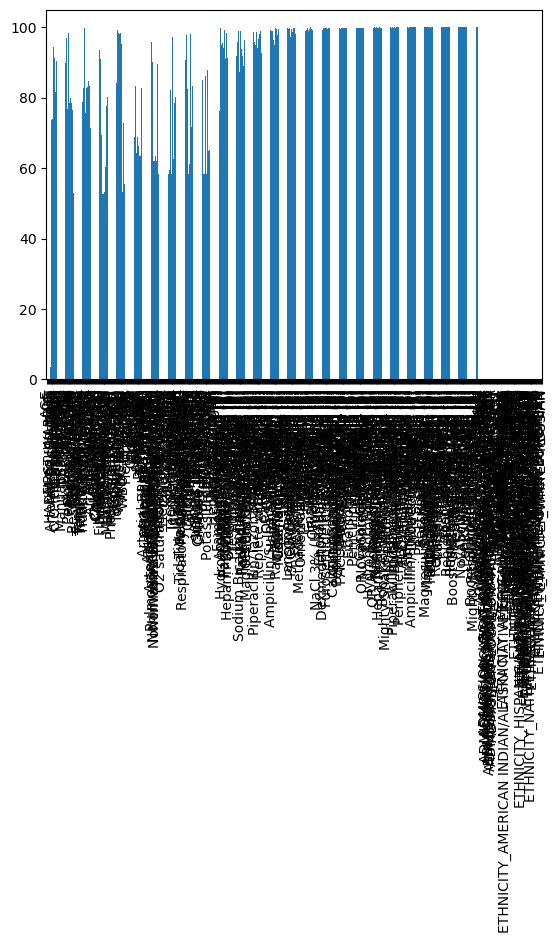

In [19]:
import matplotlib.pyplot as plt

missing_percentage = cohort.data.groupby("ICUSTAY_ID").mean().isnull().mean() * 100

missing_percentage.plot(kind="bar")
plt.show()

# Machine Learning Task

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
features, label = rus.fit_resample(features, label)
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42, stratify=label)

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(x_train, y_train)

y_pred = model.predict_proba(x_test)[:, 1]

roc_auc_score(y_test, y_pred)

0.9188943767866503

In [15]:
label.value_counts()

label
0.0    6609
1.0    6609
Name: count, dtype: int64

In [8]:
y_test.value_counts()

label
1.0    1322
0.0    1322
Name: count, dtype: int64

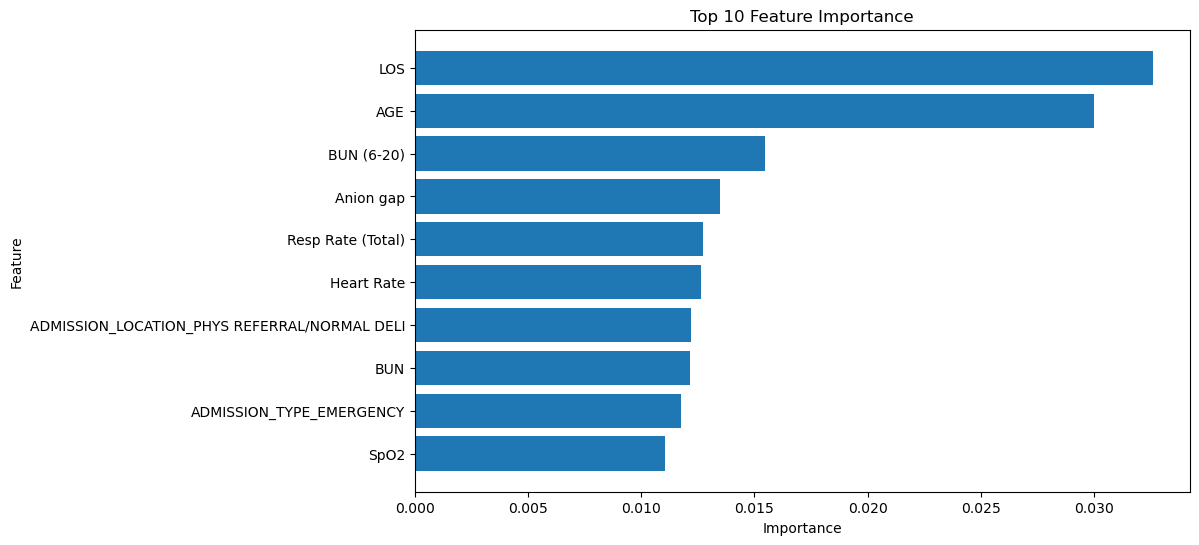

In [25]:
# 피처 중요도 추출
feature_importances = model.feature_importances_

# 피처 중요도를 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': feature_importances
})

# 피처 중요도 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 상위 10개 피처 선택
top_10_features = feature_importance_df.head(10)

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()  # 중요도가 높은 피처가 위로 오도록 정렬
plt.show()